## 1. Setup and Environment Configuration

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import os
from collections import Counter, deque
import random
import math

# Set environment variable to reduce memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

print("🔍 Checking GPU availability...")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✅ Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"✅ CUDA version: {torch.version.cuda}")
    print(f"✅ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    device = torch.device('cpu')
    print("⚠️ Using CPU - GPU not available")

🔍 Checking GPU availability...
PyTorch version: 2.8.0+cu126
CUDA available: True
✅ Using GPU: Tesla T4
✅ CUDA version: 12.6
✅ GPU Memory: 14.7 GB


## 2. Install PyTorch Geometric with GAT Support

In [2]:
# Install PyTorch Geometric if not available
try:
    from torch_geometric.data import Data
    from torch_geometric.nn import GATConv
    from torch_geometric.nn import GATv2Conv

    print("✅ PyTorch Geometric imports successful")
except ImportError:
    print("📦 Installing PyTorch Geometric...")
    !pip install -q torch-geometric
    from torch_geometric.data import Data
    from torch_geometric.nn import GATConv
    from torch_geometric.nn import GATv2Conv
    print("✅ PyTorch Geometric installed successfully")

📦 Installing PyTorch Geometric...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.4 MB/s eta 0:00:00
✅ PyTorch Geometric installed successfully


## 3. Define GAT Model Architecture

In [3]:
class EnhancedGAT3L(nn.Module):
    """3-Layer Graph Attention Network with multi-head attention"""
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.2):
        super(EnhancedGAT3L, self).__init__()

        # First GAT layer with multiple attention heads (concatenated)
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=heads, dropout=dropout, concat=True)

        # Second GAT layer with multiple attention heads (concatenated)
        self.conv2 = GATv2Conv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout, concat=True)

        # Third GAT layer (output layer) with single head (averaged)
        self.conv3 = GATv2Conv(hidden_channels * heads, out_channels, heads=1, dropout=dropout, concat=False)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm1d(hidden_channels * heads)
        self.bn2 = nn.BatchNorm1d(hidden_channels * heads)

        self.dropout = dropout
        self.residual = True

    def forward(self, x, edge_index):
        # First layer
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.elu(x1)  # ELU activation (common for GAT)
        x1 = F.dropout(x1, p=self.dropout, training=self.training)

        # Second layer with residual connection
        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        if self.residual:
            x2 = x2 + x1  # Residual connection
        x2 = F.elu(x2)
        x2 = F.dropout(x2, p=self.dropout, training=self.training)

        # Third layer
        x3 = self.conv3(x2, edge_index)

        return F.normalize(x3, p=2, dim=1)  # L2 normalize embeddings

print("✅ GAT model architecture defined")

✅ GAT model architecture defined


## 4. Define AUC-Enhanced Link Predictor

In [4]:
class AUCEnhancedLinkPredictor(nn.Module):
    """Link predictor with multiple similarity measures for better AUC"""
    def __init__(self, in_channels, hidden_dim=128, dropout=0.3):
        super(AUCEnhancedLinkPredictor, self).__init__()

        # Input: src embeddings + dst embeddings + 3 similarity features
        input_dim = 2 * in_channels + 3

        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.lin4 = nn.Linear(hidden_dim // 2, 1)

        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim // 2)

        self.dropout = nn.Dropout(dropout)
        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0.1)

    def forward(self, z, edge_index):
        src = z[edge_index[0]]
        dst = z[edge_index[1]]

        # Multiple similarity measures for better AUC
        dot_product = (src * dst).sum(dim=1, keepdim=True)
        cosine_sim = F.cosine_similarity(src, dst, dim=1).unsqueeze(1)
        euclidean_dist = torch.norm(src - dst, dim=1, keepdim=True)
        euclidean_sim = 1.0 / (1.0 + euclidean_dist)

        # Concatenate all features
        edge_features = torch.cat([src, dst, dot_product, cosine_sim, euclidean_sim], dim=1)

        # MLP layers
        mlp_output = F.leaky_relu(self.bn1(self.lin1(edge_features)), negative_slope=0.1)
        mlp_output = self.dropout(mlp_output)

        mlp_output = F.leaky_relu(self.bn2(self.lin2(mlp_output)), negative_slope=0.1)
        mlp_output = self.dropout(mlp_output)

        mlp_output = F.leaky_relu(self.bn3(self.lin3(mlp_output)), negative_slope=0.1)
        mlp_output = self.dropout(mlp_output)

        mlp_score = self.lin4(mlp_output)

        # Combine MLP output with similarity measures
        combined_score = mlp_score + 0.2 * dot_product + 0.2 * cosine_sim

        return torch.sigmoid(combined_score).squeeze()

print("✅ Link predictor defined")

✅ Link predictor defined


## 5. Feature Engineering Functions

In [5]:
def compute_auc_optimized_features(G, nodes):
    """Compute 21 AUC-optimized node features"""
    print("Computing AUC-optimized features...")
    features = []

    # Precompute metrics
    print("  - Computing basic graph metrics...")
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())
    total_degrees = {node: in_degrees.get(node, 0) + out_degrees.get(node, 0) for node in nodes}

    print("  - Computing PageRank...")
    pagerank = nx.pagerank(G, alpha=0.75, max_iter=50)

    print("  - Computing clustering coefficients...")
    clustering = nx.clustering(G)

    print("  - Computing betweenness centrality (sampled)...")
    sample_nodes = random.sample(nodes, min(1000, len(nodes)))
    betweenness = nx.betweenness_centrality_subset(G, sample_nodes, sample_nodes)

    print("  - Computing node features...")
    for node in tqdm(nodes, desc="Computing AUC features"):
        node_feats = []

        # 1. Enhanced Degree Features (8 features)
        in_deg = in_degrees.get(node, 0)
        out_deg = out_degrees.get(node, 0)
        total_deg = total_degrees.get(node, 0)
        node_feats.extend([
            in_deg, out_deg, total_deg,
            np.log1p(in_deg), np.log1p(out_deg), np.log1p(total_deg),
            in_deg / (total_deg + 1e-8),
            out_deg / (total_deg + 1e-8),
        ])

        # 2. Centrality Measures (3 features)
        node_feats.extend([
            pagerank.get(node, 0),
            clustering.get(node, 0),
            betweenness.get(node, 0),
        ])

        # 3. Neighborhood Structure (6 features)
        successors = list(G.successors(node))
        predecessors = list(G.predecessors(node))

        if successors:
            succ_degrees = [total_degrees.get(n, 0) for n in successors[:15]]
            node_feats.extend([np.mean(succ_degrees), np.std(succ_degrees), np.max(succ_degrees)])
        else:
            node_feats.extend([0, 0, 0])

        if predecessors:
            pred_degrees = [total_degrees.get(n, 0) for n in predecessors[:15]]
            node_feats.extend([np.mean(pred_degrees), np.std(pred_degrees), np.max(pred_degrees)])
        else:
            node_feats.extend([0, 0, 0])

        # 4. Reciprocity Features (2 features)
        reciprocal_count = sum(1 for succ in successors[:25] if G.has_edge(succ, node))
        node_feats.extend([
            reciprocal_count,
            reciprocal_count / (out_deg + 1e-8) if out_deg > 0 else 0,
        ])

        # 5. Structural Balance (2 features)
        node_feats.extend([
            min(len(successors), len(predecessors)) / (max(len(successors), len(predecessors)) + 1e-8),
            abs(len(successors) - len(predecessors)),
        ])

        features.append(node_feats)

    feature_array = np.array(features)
    print(f"Feature matrix shape: {feature_array.shape}")
    return feature_array

print("✅ Feature engineering functions defined")

✅ Feature engineering functions defined


In [6]:
def visualize_node_features(feature_matrix, sample_size=1000, save_path='node_features_analysis.png'):
    """
    Visualize node features with multiple plots

    Args:
        feature_matrix: numpy array of shape (num_nodes, num_features)
        sample_size: number of nodes to sample for visualization
        save_path: path to save the visualization
    """
    print(f"📊 Visualizing node features...")

    # Sample nodes if dataset is too large
    if feature_matrix.shape[0] > sample_size:
        indices = np.random.choice(feature_matrix.shape[0], sample_size, replace=False)
        features_sample = feature_matrix[indices]
    else:
        features_sample = feature_matrix

    num_features = feature_matrix.shape[1]

    # Feature names based on the compute_auc_optimized_features function
    feature_names = [
        # Degree features (8)
        'In-Degree', 'Out-Degree', 'Total-Degree',
        'Log(In-Deg+1)', 'Log(Out-Deg+1)', 'Log(Total-Deg+1)',
        'In/Total Ratio', 'Out/Total Ratio',
        # Centrality (3 or 5 depending on version)
        'PageRank', 'Clustering', 'Betweenness',
        'Closeness', 'Eigenvector',  # May not exist in all versions
        # Neighborhood (6)
        'Succ-Deg Mean', 'Succ-Deg Std', 'Succ-Deg Max',
        'Pred-Deg Mean', 'Pred-Deg Std', 'Pred-Deg Max',
        # Reciprocity (2)
        'Reciprocal Count', 'Reciprocal Ratio',
        # Structural Balance (2)
        'Balance Ratio', 'Balance Diff',
        # Additional features if 35 total
        'Triangles', 'Tri/Out-Deg', 'Tri/In-Deg', 'Tri/Total-Deg',
        'Common Neighbors', 'Jaccard', 'Overlap-Succ', 'Overlap-Pred',
        'K-Core', 'K-Core Ratio',
        'Ego Density', 'Ego Size',
    ]

    # Trim to actual number of features
    feature_names = feature_names[:num_features]

    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

    # 1. Feature Distribution Heatmap
    ax1 = fig.add_subplot(gs[0, :])
    features_normalized = (features_sample - features_sample.min(axis=0)) / (features_sample.max(axis=0) - features_sample.min(axis=0) + 1e-8)
    im = ax1.imshow(features_normalized[:50].T, aspect='auto', cmap='viridis', interpolation='nearest')
    ax1.set_title('Feature Values Heatmap (First 50 Nodes)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Node Index')
    ax1.set_ylabel('Feature Index')
    ax1.set_yticks(range(num_features))
    ax1.set_yticklabels(feature_names, fontsize=8)
    plt.colorbar(im, ax=ax1, label='Normalized Value')

    # 2. Feature Distribution (Box Plot)
    ax2 = fig.add_subplot(gs[1, :])
    positions = np.arange(num_features)
    bp = ax2.boxplot([feature_matrix[:, i] for i in range(num_features)],
                     positions=positions, patch_artist=True, showfliers=False)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    ax2.set_xticks(positions)
    ax2.set_xticklabels(feature_names, rotation=90, fontsize=8)
    ax2.set_title('Feature Value Distributions (Box Plot)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Feature Value')
    ax2.grid(True, alpha=0.3, axis='y')

    # 3. Feature Statistics Table
    ax3 = fig.add_subplot(gs[2, 0])
    ax3.axis('off')
    stats_data = []
    for i in range(min(10, num_features)):
        feat_vals = feature_matrix[:, i]
        stats_data.append([
            feature_names[i][:15],
            f'{np.mean(feat_vals):.3f}',
            f'{np.std(feat_vals):.3f}',
            f'{np.min(feat_vals):.2f}',
            f'{np.max(feat_vals):.2f}'
        ])

    table = ax3.table(cellText=stats_data,
                     colLabels=['Feature', 'Mean', 'Std', 'Min', 'Max'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.3, 0.15, 0.15, 0.15, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 2)
    ax3.set_title('Feature Statistics (First 10 Features)', fontsize=12, fontweight='bold', pad=20)

    # 4. Feature Correlation Heatmap
    ax4 = fig.add_subplot(gs[2, 1:])
    # Sample features for correlation to avoid overcrowding
    features_for_corr = min(15, num_features)
    corr_matrix = np.corrcoef(feature_matrix[:, :features_for_corr].T)
    im2 = ax4.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
    ax4.set_title('Feature Correlation Matrix (First 15 Features)', fontsize=12, fontweight='bold')
    ax4.set_xticks(range(features_for_corr))
    ax4.set_yticks(range(features_for_corr))
    ax4.set_xticklabels(feature_names[:features_for_corr], rotation=90, fontsize=8)
    ax4.set_yticklabels(feature_names[:features_for_corr], fontsize=8)
    plt.colorbar(im2, ax=ax4, label='Correlation')

    # 5. Feature Variance Analysis
    ax5 = fig.add_subplot(gs[3, 0])
    variances = np.var(feature_matrix, axis=0)
    sorted_indices = np.argsort(variances)[::-1]
    top_10 = sorted_indices[:10]
    ax5.barh(range(10), variances[top_10], color='steelblue')
    ax5.set_yticks(range(10))
    ax5.set_yticklabels([feature_names[i] for i in top_10], fontsize=9)
    ax5.set_xlabel('Variance')
    ax5.set_title('Top 10 Features by Variance', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='x')
    ax5.invert_yaxis()

    # 6. Feature Sparsity Analysis
    ax6 = fig.add_subplot(gs[3, 1])
    zero_counts = np.sum(feature_matrix == 0, axis=0) / feature_matrix.shape[0] * 100
    non_sparse_features = np.where(zero_counts < 90)[0][:15]  # Features with <90% zeros
    ax6.bar(range(len(non_sparse_features)), zero_counts[non_sparse_features], color='coral')
    ax6.set_xticks(range(len(non_sparse_features)))
    ax6.set_xticklabels([feature_names[i] for i in non_sparse_features], rotation=90, fontsize=8)
    ax6.set_ylabel('% Zero Values')
    ax6.set_title('Feature Sparsity (Non-Sparse Features)', fontsize=12, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')

    # 7. Feature Distribution Histograms (Selected Features)
    ax7 = fig.add_subplot(gs[3, 2])
    selected_features = [0, 1, 8, 11]  # In-degree, Out-degree, PageRank, Closeness/Succ-Deg-Mean
    colors = ['blue', 'green', 'red', 'purple']
    for idx, feat_idx in enumerate(selected_features[:min(len(selected_features), num_features)]):
        ax7.hist(feature_matrix[:, feat_idx], bins=30, alpha=0.5,
                label=feature_names[feat_idx], color=colors[idx], density=True)
    ax7.set_xlabel('Feature Value')
    ax7.set_ylabel('Density')
    ax7.set_title('Selected Feature Distributions', fontsize=12, fontweight='bold')
    ax7.legend(fontsize=8)
    ax7.grid(True, alpha=0.3)

    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Feature visualization saved to: {save_path}")
    plt.show()

    # Print summary statistics
    print(f"\n📈 Feature Summary:")
    print(f"   Total features: {num_features}")
    print(f"   Total nodes: {feature_matrix.shape[0]}")
    print(f"   Feature matrix shape: {feature_matrix.shape}")
    print(f"   Memory usage: {feature_matrix.nbytes / 1024**2:.2f} MB")
    print(f"\n   Top 5 features by variance:")
    for i, idx in enumerate(sorted_indices[:5]):
        print(f"      {i+1}. {feature_names[idx]}: {variances[idx]:.4f}")

def visualize_feature_pca(feature_matrix, labels=None, save_path='feature_pca_analysis.png'):
    """
    Visualize features using PCA for dimensionality reduction

    Args:
        feature_matrix: numpy array of shape (num_nodes, num_features)
        labels: optional node labels for coloring
        save_path: path to save the visualization
    """
    from sklearn.decomposition import PCA

    print(f"📊 Performing PCA analysis...")

    # Perform PCA
    pca = PCA(n_components=min(10, feature_matrix.shape[1]))
    features_pca = pca.fit_transform(feature_matrix)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. PCA 2D Scatter
    ax1 = axes[0, 0]
    if labels is not None:
        scatter = ax1.scatter(features_pca[:, 0], features_pca[:, 1],
                            c=labels, cmap='viridis', alpha=0.6, s=20)
        plt.colorbar(scatter, ax=ax1, label='Node Label')
    else:
        ax1.scatter(features_pca[:, 0], features_pca[:, 1],
                   alpha=0.6, s=20, color='steelblue')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax1.set_title('Node Features in PCA Space (2D)', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # 2. Explained Variance
    ax2 = axes[0, 1]
    cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
    ax2.plot(range(1, len(pca.explained_variance_ratio_) + 1),
            pca.explained_variance_ratio_, 'bo-', label='Individual')
    ax2.plot(range(1, len(cumsum_variance) + 1),
            cumsum_variance, 'rs-', label='Cumulative')
    ax2.set_xlabel('Principal Component')
    ax2.set_ylabel('Explained Variance Ratio')
    ax2.set_title('PCA Explained Variance', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Component Loadings
    ax3 = axes[1, 0]
    loadings = pca.components_[:3].T
    im = ax3.imshow(loadings, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)
    ax3.set_xlabel('Principal Component')
    ax3.set_ylabel('Original Feature Index')
    ax3.set_title('Feature Loadings (First 3 PCs)', fontsize=12, fontweight='bold')
    ax3.set_xticks([0, 1, 2])
    ax3.set_xticklabels(['PC1', 'PC2', 'PC3'])
    plt.colorbar(im, ax=ax3, label='Loading')

    # 4. 3D PCA (if enough components)
    if features_pca.shape[1] >= 3:
        ax4 = axes[1, 1]
        ax4.remove()
        ax4 = fig.add_subplot(2, 2, 4, projection='3d')
        if labels is not None:
            scatter = ax4.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2],
                                c=labels, cmap='viridis', alpha=0.6, s=10)
        else:
            ax4.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2],
                       alpha=0.6, s=10, color='steelblue')
        ax4.set_xlabel('PC1')
        ax4.set_ylabel('PC2')
        ax4.set_zlabel('PC3')
        ax4.set_title('Node Features in PCA Space (3D)', fontsize=12, fontweight='bold')
    else:
        ax4 = axes[1, 1]
        ax4.text(0.5, 0.5, 'Not enough components\nfor 3D visualization',
                ha='center', va='center', fontsize=12)
        ax4.axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ PCA visualization saved to: {save_path}")
    plt.show()

    print(f"\n📈 PCA Summary:")
    print(f"   Total variance explained by first 3 PCs: {cumsum_variance[2]:.2%}")
    print(f"   Components needed for 95% variance: {np.argmax(cumsum_variance >= 0.95) + 1}")

print("✅ Feature visualization functions defined")

✅ Feature visualization functions defined


## 6. Data Loading and Preprocessing

In [7]:
def load_and_preprocess_data(sample_fraction=0.05):
    """Load data and compute features"""
    print("📂 Loading and preprocessing data...")

    try:
        df = pd.read_csv('data/train.csv')
        print(f"✅ Train data loaded: {len(df)} edges")
    except FileNotFoundError:
        df = pd.read_csv('train.csv')
        print(f"✅ Train data loaded: {len(df)} edges")

    df = df.sample(frac=sample_fraction, random_state=42)
    print(f"Using {len(df)} edges ({sample_fraction*100}% of data)")

    # Create graph
    G = nx.DiGraph()
    edges = list(zip(df['source_node'], df['destination_node']))
    G.add_edges_from(edges)

    print(f"\nGraph Statistics:")
    print(f"  - Nodes: {G.number_of_nodes()}")
    print(f"  - Edges: {G.number_of_edges()}")
    print(f"  - Avg in-degree: {np.mean([d for n, d in G.in_degree()]):.2f}")
    print(f"  - Avg out-degree: {np.mean([d for n, d in G.out_degree()]):.2f}")

    # Create node mapping
    nodes = list(G.nodes())
    node_mapping = {node: idx for idx, node in enumerate(nodes)}

    # Compute features (ONLY ONCE)
    node_feature_matrix = compute_auc_optimized_features(G, nodes)

    # Store raw features for visualization BEFORE normalization
    raw_features = node_feature_matrix.copy()

    # Normalize features
    scaler = StandardScaler()
    node_feature_matrix = scaler.fit_transform(node_feature_matrix)

    # Create edge index for PyG
    edge_index = []
    for edge in G.edges():
        src_idx = node_mapping[edge[0]]
        dst_idx = node_mapping[edge[1]]
        edge_index.append([src_idx, dst_idx])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Convert to tensors and move to device
    x = torch.tensor(node_feature_matrix, dtype=torch.float).to(device)
    edge_index = edge_index.to(device)

    # Create Data object
    data = Data(x=x, edge_index=edge_index)
    data.num_nodes = len(nodes)

    return data, G, node_mapping, raw_features

print("✅ Data loading function defined")

✅ Data loading function defined


## 7. Train/Val/Test Split

In [8]:
def train_test_split_edges(data, val_ratio=0.05, test_ratio=0.1):
    """Split edges into train/val/test with negative sampling"""
    num_nodes = data.num_nodes
    row, col = data.edge_index

    # Remove self-loops
    mask = row != col
    row, col = row[mask], col[mask]

    # Random split
    num_edges = row.size(0)
    num_val = int(num_edges * val_ratio)
    num_test = int(num_edges * test_ratio)

    perm = torch.randperm(num_edges, device=device)
    row, col = row[perm], col[perm]

    # Split edges
    test_edge_index = torch.stack([row[:num_test], col[:num_test]], dim=0)
    val_edge_index = torch.stack([row[num_test:num_test+num_val], col[num_test:num_test+num_val]], dim=0)
    train_edge_index = torch.stack([row[num_test+num_val:], col[num_test+num_val:]], dim=0)

    def negative_sampling(num_nodes, num_neg_samples):
        num_neg_samples = min(num_neg_samples, 8000)
        neg_edges = torch.randint(0, num_nodes, (2, num_neg_samples), device=device)
        # Ensure no self-loops
        for i in range(neg_edges.size(1)):
            if neg_edges[0, i] == neg_edges[1, i]:
                new_dst = torch.randint(0, num_nodes, (1,), device=device)
                while new_dst == neg_edges[0, i]:
                    new_dst = torch.randint(0, num_nodes, (1,), device=device)
                neg_edges[1, i] = new_dst
        return neg_edges

    data.train_pos_edge_index = train_edge_index
    data.val_pos_edge_index = val_edge_index
    data.val_neg_edge_index = negative_sampling(num_nodes, num_val)
    data.test_pos_edge_index = test_edge_index
    data.test_neg_edge_index = negative_sampling(num_nodes, num_test)

    print(f"Train edges: {train_edge_index.size(1)}")
    print(f"Val edges: {val_edge_index.size(1)}")
    print(f"Test edges: {test_edge_index.size(1)}")

    return data

print("✅ Train/test split function defined")

✅ Train/test split function defined


## 8. Training Function

In [9]:
def train_gat(model, predictor, data, epochs=80):
    """Train GAT model with early stopping"""
    model = model.to(device)
    predictor = predictor.to(device)
    data = data.to(device)

    optimizer = torch.optim.AdamW(
        list(model.parameters()) + list(predictor.parameters()),
        lr=0.001, weight_decay=1e-5
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10
    )

    train_losses = []
    val_f1_scores = []
    val_auc_scores = []
    best_val_auc = 0.0
    patience_counter = 0

    torch.cuda.empty_cache()

    pbar = tqdm(range(epochs), desc="Training GAT")
    for epoch in pbar:
        model.train()
        predictor.train()
        optimizer.zero_grad()

        # Get embeddings
        z = model(data.x, data.train_pos_edge_index)

        # Positive edges loss
        pos_out = predictor(z, data.train_pos_edge_index)
        pos_loss = F.binary_cross_entropy(pos_out, torch.ones_like(pos_out))

        # Negative sampling
        neg_samples = min(data.train_pos_edge_index.size(1) // 3, 2500)
        neg_src = torch.randint(0, z.size(0), (neg_samples,), device=device)
        neg_dst = torch.randint(0, z.size(0), (neg_samples,), device=device)
        neg_edge_index = torch.stack([neg_src, neg_dst])

        neg_out = predictor(z, neg_edge_index)
        neg_loss = F.binary_cross_entropy(neg_out, torch.zeros_like(neg_out))

        # Combined loss
        loss = pos_loss + neg_loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(predictor.parameters(), max_norm=1.0)

        optimizer.step()
        train_losses.append(loss.item())

        # Validation every 3 epochs
        if epoch % 3 == 0 or epoch == epochs - 1:
            model.eval()
            predictor.eval()
            with torch.no_grad():
                z_val = model(data.x, data.train_pos_edge_index)

                # Process validation in batches
                batch_size = 6000
                val_preds, val_trues = [], []

                for i in range(0, data.val_pos_edge_index.size(1), batch_size):
                    end_idx = min(i + batch_size, data.val_pos_edge_index.size(1))
                    batch_edges = data.val_pos_edge_index[:, i:end_idx]
                    val_preds.append(predictor(z_val, batch_edges))
                    val_trues.append(torch.ones(batch_edges.size(1), device=device))

                for i in range(0, data.val_neg_edge_index.size(1), batch_size):
                    end_idx = min(i + batch_size, data.val_neg_edge_index.size(1))
                    batch_edges = data.val_neg_edge_index[:, i:end_idx]
                    val_preds.append(predictor(z_val, batch_edges))
                    val_trues.append(torch.zeros(batch_edges.size(1), device=device))

                val_pred = torch.cat(val_preds).cpu().numpy()
                val_true = torch.cat(val_trues).cpu().numpy()
                val_pred_binary = (val_pred > 0.5).astype(int)
                val_f1 = f1_score(val_true, val_pred_binary)

                fpr, tpr, _ = roc_curve(val_true, val_pred)
                val_auc = auc(fpr, tpr)

                val_f1_scores.append(val_f1)
                val_auc_scores.append(val_auc)
                scheduler.step(val_auc)

            # Early stopping
            if epoch >= 15:
                if val_auc > best_val_auc:
                    best_val_auc = val_auc
                    patience_counter = 0
                    torch.save({
                        'model_state_dict': model.state_dict(),
                        'predictor_state_dict': predictor.state_dict(),
                    }, 'best_gat_model.pth')
                else:
                    patience_counter += 1
                if patience_counter >= 20:
                    print(f"\n🛑 Early stopping at epoch {epoch}")
                    break

        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Val F1': f'{val_f1 if epoch % 3 == 0 else val_f1_scores[-1] if val_f1_scores else 0:.4f}',
            'Val AUC': f'{val_auc if epoch % 3 == 0 else val_auc_scores[-1] if val_auc_scores else 0:.4f}'
        })

        if epoch % 10 == 0:
            torch.cuda.empty_cache()

    # Load best model
    if os.path.exists('best_gat_model.pth'):
        checkpoint = torch.load('best_gat_model.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        predictor.load_state_dict(checkpoint['predictor_state_dict'])
        print(f"✅ Loaded best model with validation AUC: {best_val_auc:.4f}")

    return train_losses, val_f1_scores, val_auc_scores

print("✅ Training function defined")

✅ Training function defined


## 9. Evaluation Function

In [10]:
def evaluate_gat(model, predictor, data):
    """Evaluate GAT model on test set"""
    model.eval()
    predictor.eval()

    with torch.no_grad():
        z = model(data.x, data.train_pos_edge_index)

        batch_size = 6000
        all_pred, all_true = [], []

        # Process positive edges
        for i in range(0, data.test_pos_edge_index.size(1), batch_size):
            end_idx = min(i + batch_size, data.test_pos_edge_index.size(1))
            batch_edge_index = data.test_pos_edge_index[:, i:end_idx]
            all_pred.append(predictor(z, batch_edge_index))
            all_true.append(torch.ones(batch_edge_index.size(1), device=device))

        # Process negative edges
        for i in range(0, data.test_neg_edge_index.size(1), batch_size):
            end_idx = min(i + batch_size, data.test_neg_edge_index.size(1))
            batch_edge_index = data.test_neg_edge_index[:, i:end_idx]
            all_pred.append(predictor(z, batch_edge_index))
            all_true.append(torch.zeros(batch_edge_index.size(1), device=device))

        all_pred_tensor = torch.cat(all_pred).cpu().numpy()
        all_true_tensor = torch.cat(all_true).cpu().numpy()

        # Calculate metrics
        pred_binary = (all_pred_tensor > 0.5).astype(int)
        f1 = f1_score(all_true_tensor, pred_binary)
        cm = confusion_matrix(all_true_tensor, pred_binary)

        fpr, tpr, _ = roc_curve(all_true_tensor, all_pred_tensor)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(all_true_tensor, all_pred_tensor)
        avg_precision = average_precision_score(all_true_tensor, all_pred_tensor)

    return all_pred_tensor, all_true_tensor, f1, cm, fpr, tpr, roc_auc, precision, recall, avg_precision

print("✅ Evaluation function defined")

✅ Evaluation function defined


## 10. Visualization Function

In [11]:
def plot_gat_results(train_losses, val_f1_scores, val_auc_scores, fpr, tpr, roc_auc,
                     precision, recall, avg_precision, cm, f1_score_val):
    """Plot comprehensive GAT results"""
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 12))

    # 1. Training Loss
    ax1.plot(train_losses, linewidth=2, color='blue')
    ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)

    # 2. Validation Metrics
    if val_f1_scores and val_auc_scores:
        val_epochs = [i * 3 for i in range(len(val_f1_scores))]
        ax2.plot(val_epochs, val_f1_scores, label='Val F1', linewidth=2, color='green')
        ax2.plot(val_epochs, val_auc_scores, label='Val AUC', linewidth=2, color='purple')
        ax2.set_title('Validation Metrics Over Time', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Score')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, 1.0)

    # 3. ROC Curve
    ax3.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC (AUC = {roc_auc:.4f})')
    ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('False Positive Rate', fontweight='bold')
    ax3.set_ylabel('True Positive Rate', fontweight='bold')
    ax3.set_title('ROC Curve', fontsize=14, fontweight='bold')
    ax3.legend(loc="lower right")
    ax3.grid(True, alpha=0.3)

    # 4. Precision-Recall Curve
    ax4.plot(recall, precision, color='green', lw=3, label=f'PR (AP = {avg_precision:.4f})')
    ax4.set_xlim([0.0, 1.0])
    ax4.set_ylim([0.0, 1.05])
    ax4.set_xlabel('Recall', fontweight='bold')
    ax4.set_ylabel('Precision', fontweight='bold')
    ax4.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    ax4.legend(loc="lower left")
    ax4.grid(True, alpha=0.3)

    # 5. Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Neg', 'Pred Pos'],
                yticklabels=['Actual Neg', 'Actual Pos'],
                ax=ax5, annot_kws={"size": 12})
    ax5.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Predicted Label', fontweight='bold')
    ax5.set_ylabel('True Label', fontweight='bold')

    # 6. Performance Comparison
    models = ['GraphSAGE', 'XGBoost', 'GAT (Ours)']
    f1_scores = [0.517, 0.928, f1_score_val]
    auc_scores = [0.785, 0.932, roc_auc]

    x = np.arange(len(models))
    width = 0.35

    ax6.bar(x - width/2, f1_scores, width, label='F1-Score', color='lightblue', edgecolor='black')
    ax6.bar(x + width/2, auc_scores, width, label='AUC-ROC', color='lightcoral', edgecolor='black')
    ax6.set_xlabel('Models')
    ax6.set_ylabel('Scores')
    ax6.set_title('Performance Comparison', fontsize=14, fontweight='bold')
    ax6.set_xticks(x)
    ax6.set_xticklabels(models, rotation=45)
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    ax6.set_ylim(0, 1.0)

    for i, (f1, auc_val) in enumerate(zip(f1_scores, auc_scores)):
        ax6.text(i - width/2, f1 + 0.01, f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')
        ax6.text(i + width/2, auc_val + 0.01, f'{auc_val:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig('gat_comprehensive_results.png', dpi=300, bbox_inches='tight')
    plt.show()

print("✅ Visualization function defined")

✅ Visualization function defined


## 11. Main Execution: Run GAT Benchmark

In [12]:
def run_gat_benchmark():
    """Main function to run GAT benchmark"""
    print("\n" + "="*70)
    print("🚀 GAT LINK PREDICTION BENCHMARK - 5% Data")
    print("="*70)

    try:
        # Load data (features computed ONCE here)
        data, G, node_mapping, raw_features = load_and_preprocess_data(sample_fraction=0.05)

        # ===== VISUALIZE RAW FEATURES BEFORE TRAINING =====
        print("\n" + "="*70)
        print("📊 VISUALIZING NODE FEATURES (Before Training)")
        print("="*70)

        # Visualize features (using raw features from load function - NO recomputation!)
        print("\n🎨 Creating comprehensive feature visualizations...")
        visualize_node_features(raw_features, sample_size=1000,
                               save_path='node_features_analysis.png')

        print("\n🎨 Creating PCA visualizations...")
        visualize_feature_pca(raw_features, save_path='feature_pca_analysis.png')

        print("\n✅ Feature visualizations complete!")
        print("="*70)

        data = train_test_split_edges(data)

        print(f"\nFeature dimension: {data.num_features}")
        print(f"GPU Memory: {torch.cuda.memory_allocated()/1024**3:.2f} GB")

        # Initialize models
        model = EnhancedGAT3L(
            in_channels=data.num_features,
            hidden_channels=48,  # 24 * 4 heads = 96 total
            out_channels=48,
            heads=4,
            dropout=0.2
        )
        predictor = AUCEnhancedLinkPredictor(48, hidden_dim=128, dropout=0.3)

        print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")
        print(f"Predictor parameters: {sum(p.numel() for p in predictor.parameters()):,}")

        # Train
        print("\n" + "="*50)
        print("Training GAT...")
        print("="*50)
        train_losses, val_f1_scores, val_auc_scores = train_gat(model, predictor, data, epochs=80)

        # Evaluate
        print("\n" + "="*50)
        print("Evaluating GAT...")
        print("="*50)
        results = evaluate_gat(model, predictor, data)
        all_pred, all_true, f1, cm, fpr, tpr, roc_auc, precision, recall, avg_precision = results

        # Print results
        print(f"\n📊 GAT Performance:")
        print(f"   F1-Score: {f1:.4f}")
        print(f"   AUC-ROC: {roc_auc:.4f}")
        print(f"   Average Precision: {avg_precision:.4f}")

        print(f"\n🔍 Baseline Comparison:")
        print(f"   GraphSAGE F1: 0.517 | AUC: 0.785")
        print(f"   XGBoost F1: 0.928 | AUC: 0.932")
        print(f"   GAT F1: {f1:.3f} | AUC: {roc_auc:.3f}")

        improvement_f1 = ((f1 - 0.517) / 0.517) * 100
        improvement_auc = ((roc_auc - 0.785) / 0.785) * 100

        print(f"\n📈 Improvement vs GraphSAGE:")
        print(f"   F1-Score: {improvement_f1:+.2f}%")
        print(f"   AUC-ROC: {improvement_auc:+.2f}%")

        # Plot results
        print("\n📊 Generating model performance visualizations...")
        plot_gat_results(train_losses, val_f1_scores, val_auc_scores, fpr, tpr, roc_auc,
                        precision, recall, avg_precision, cm, f1)

        # Save results
        print("\n💾 Saving results...")
        pd.DataFrame({
            'true_labels': all_true,
            'predicted_scores': all_pred,
            'predicted_binary': (all_pred > 0.5).astype(int)
        }).to_csv('gat_predictions.csv', index=False)

        pd.DataFrame({
            'metric': ['F1-Score', 'AUC-ROC', 'Avg_Precision'],
            'score': [f1, roc_auc, avg_precision]
        }).to_csv('gat_metrics.csv', index=False)

        print("\n✅ GAT BENCHMARK COMPLETED!")
        print(f"   Results saved: gat_predictions.csv, gat_metrics.csv")
        print(f"   Visualizations saved:")
        print(f"      - node_features_analysis.png (Feature analysis)")
        print(f"      - feature_pca_analysis.png (PCA visualization)")
        print(f"      - gat_comprehensive_results.png (Model performance)")

        return {
            'f1': f1,
            'auc': roc_auc,
            'avg_precision': avg_precision
        }

    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None
    finally:
        torch.cuda.empty_cache()

print("✅ Main execution function defined")

✅ Main execution function defined


## 12. Run the Benchmark


🚀 GAT LINK PREDICTION BENCHMARK - 5% Data
📂 Loading and preprocessing data...
✅ Train data loaded: 9437519 edges
Using 471876 edges (5.0% of data)

Graph Statistics:
  - Nodes: 549393
  - Edges: 471876
  - Avg in-degree: 0.86
  - Avg out-degree: 0.86
Computing AUC-optimized features...
  - Computing basic graph metrics...
  - Computing PageRank...
  - Computing clustering coefficients...
  - Computing betweenness centrality (sampled)...
  - Computing node features...


Computing AUC features: 100%|██████████| 549393/549393 [00:40<00:00, 13420.23it/s]


Feature matrix shape: (549393, 21)

📊 VISUALIZING NODE FEATURES (Before Training)

🎨 Creating comprehensive feature visualizations...
📊 Visualizing node features...
✅ Feature visualization saved to: node_features_analysis.png


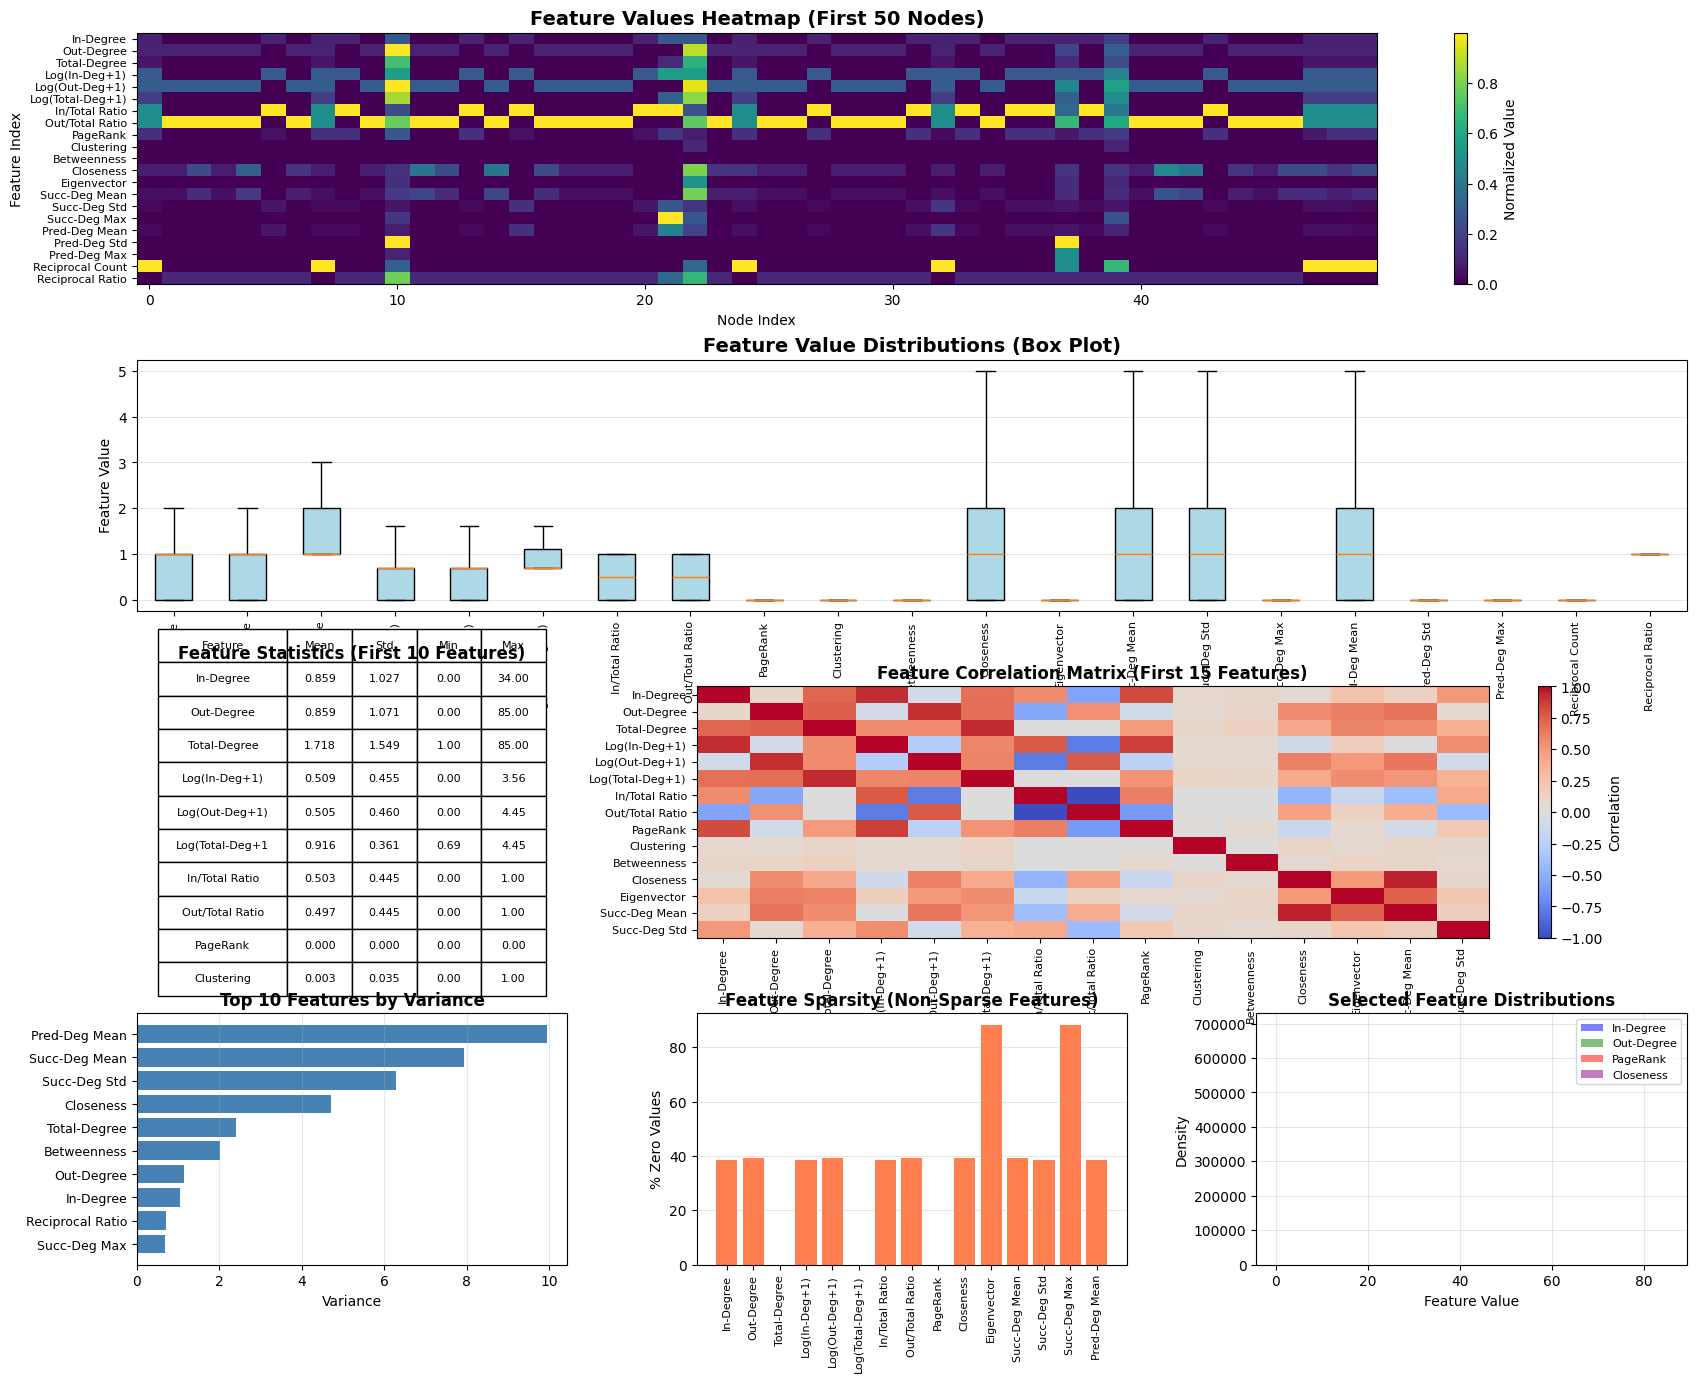


📈 Feature Summary:
   Total features: 21
   Total nodes: 549393
   Feature matrix shape: (549393, 21)
   Memory usage: 88.02 MB

   Top 5 features by variance:
      1. Pred-Deg Mean: 9.9380
      2. Succ-Deg Mean: 7.9377
      3. Succ-Deg Std: 6.2756
      4. Closeness: 4.6965
      5. Total-Degree: 2.3996

🎨 Creating PCA visualizations...
📊 Performing PCA analysis...
✅ PCA visualization saved to: feature_pca_analysis.png


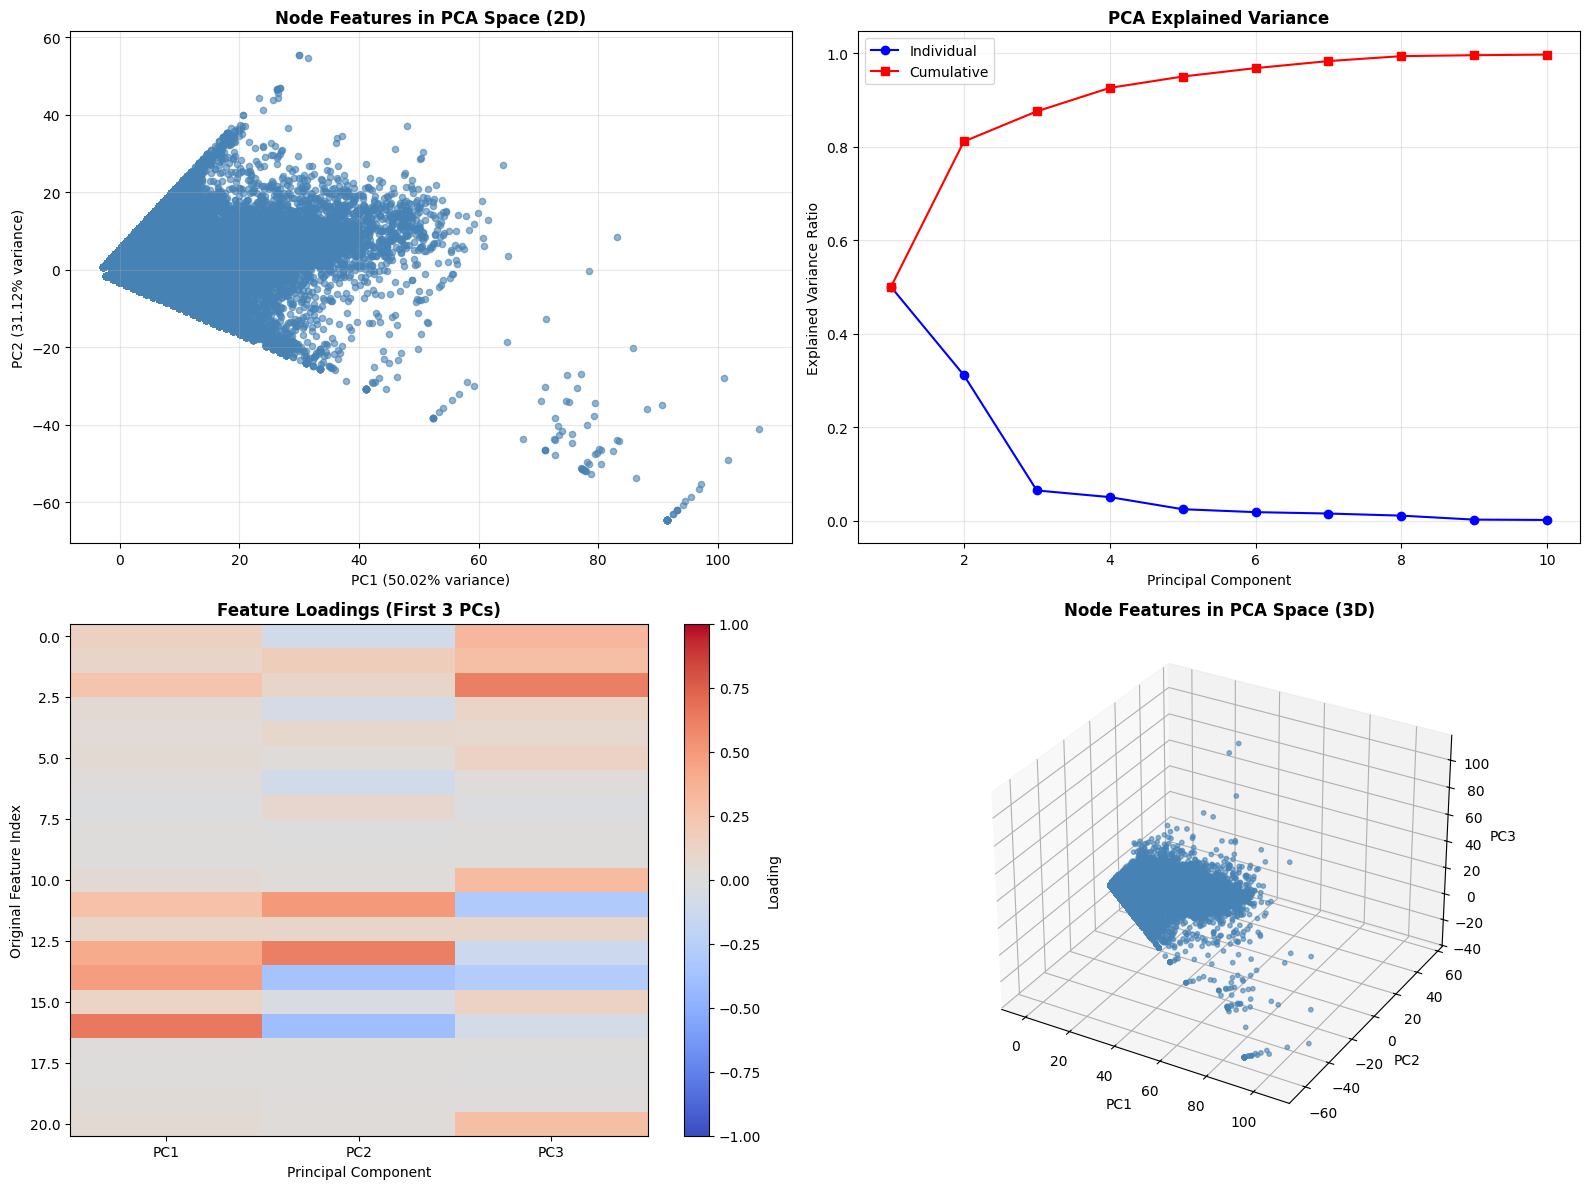


📈 PCA Summary:
   Total variance explained by first 3 PCs: 87.59%
   Components needed for 95% variance: 5

✅ Feature visualizations complete!
Train edges: 401096
Val edges: 23593
Test edges: 47187

Feature dimension: 21
GPU Memory: 0.06 GB

Model parameters: 102,720
Predictor parameters: 38,273

Training GAT...


Training GAT:  99%|█████████▉| 79/80 [01:05<00:00,  1.21it/s, Loss=0.8910, Val F1=0.5587, Val AUC=0.5647]


🛑 Early stopping at epoch 79
✅ Loaded best model with validation AUC: 0.6217

Evaluating GAT...



📊 GAT Performance:
   F1-Score: 0.8003
   AUC-ROC: 0.6241
   Average Precision: 0.9079

🔍 Baseline Comparison:
   GraphSAGE F1: 0.517 | AUC: 0.785
   XGBoost F1: 0.928 | AUC: 0.932
   GAT F1: 0.800 | AUC: 0.624

📈 Improvement vs GraphSAGE:
   F1-Score: +54.80%
   AUC-ROC: -20.50%

📊 Generating model performance visualizations...


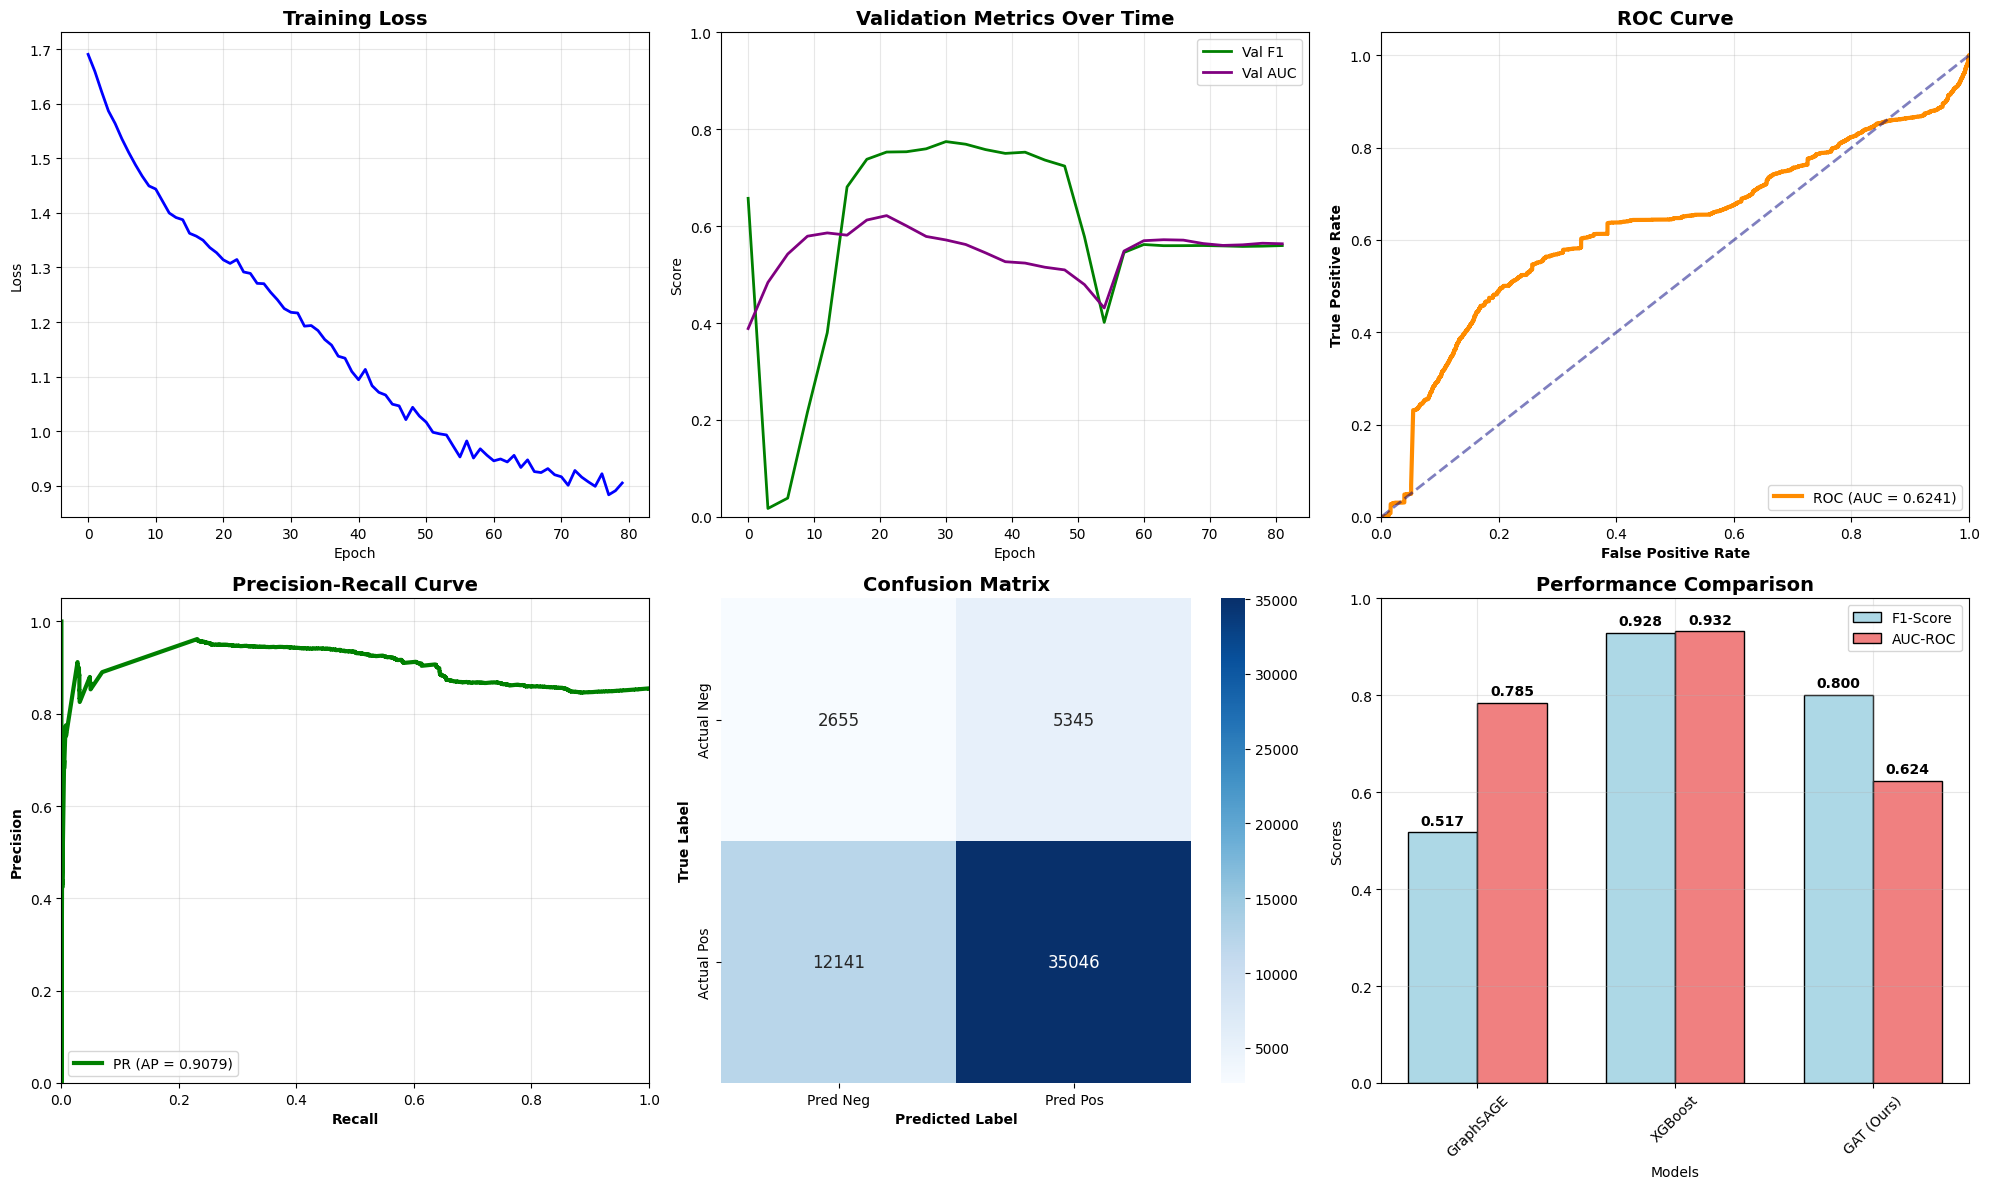


💾 Saving results...

✅ GAT BENCHMARK COMPLETED!
   Results saved: gat_predictions.csv, gat_metrics.csv
   Visualizations saved:
      - node_features_analysis.png (Feature analysis)
      - feature_pca_analysis.png (PCA visualization)
      - gat_comprehensive_results.png (Model performance)

🎉 FINAL GAT BENCHMARK RESULTS
F1-Score: 0.8003
AUC-ROC: 0.6241
Average Precision: 0.9079


In [13]:
# Execute the GAT benchmark
results = run_gat_benchmark()

if results:
    print("\n" + "="*70)
    print("🎉 FINAL GAT BENCHMARK RESULTS")
    print("="*70)
    print(f"F1-Score: {results['f1']:.4f}")
    print(f"AUC-ROC: {results['auc']:.4f}")
    print(f"Average Precision: {results['avg_precision']:.4f}")
    print("="*70)